<h1 style="text-align:center; 
           font-weight:bold;
           font-size:180%">
        An Implementation of Single Shot MultiBox Detector (SSD)</h1>
<h2> <u>Dataset</u>: Udacity Self Driving Car </h2>

More details are available at https://github.com/udacity/self-driving-car/tree/master/annotations

In [1]:
from google.colab import drive
drive.mount('./gdrive')

%cd /content/gdrive/MyDrive/Colab Notebooks/SSD_udacitytraffic

Mounted at ./gdrive
/content/gdrive/MyDrive/Colab Notebooks/SSD_udacitytraffic


# 1. Import required packages

In [ ]:
!git clone https://github.com/pierluigiferrari/ssd_keras

fatal: destination path 'ssd_keras' already exists and is not an empty directory.


In [2]:
%tensorflow_version 1.x
!pip install keras==2.1.4

TensorFlow 1.x selected.
     |████████████████████████████████| 327kB 18.0MB/s 
ERROR: textgenrnn 1.4.1 has requirement keras>=2.1.5, but you'll have keras 2.1.4 which is incompatible.
  Found existing installation: Keras 2.3.1
    Uninstalling Keras-2.3.1:
      Successfully uninstalled Keras-2.3.1


In [3]:
import tensorflow as tf
import keras

print('Tensorflow version: ', tf.__version__)
print('Keras version: ', keras.__version__)

Tensorflow version:  1.15.2
Keras version:  2.1.4


Using TensorFlow backend.


In [4]:
import sys
sys.path.append('./ssd_keras')

import os
from os.path import join
import shutil
import h5py
import threading
import time 
import random
import glob
from tqdm import tqdm
import numpy as np
from math import ceil
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import cv2

import warnings
warnings.filterwarnings("ignore")

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
from ssd_keras import keras_layers
from ssd_keras import keras_loss_function
from ssd_keras import models
from ssd_keras import ssd_encoder_decoder
from ssd_keras import data_generator
from ssd_keras import misc_utils
from ssd_keras import bounding_box_utils

from misc_utils.tensor_sampling_utils import sample_tensors

from keras.optimizers import Adam, SGD
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, \
                            TerminateOnNaN, CSVLogger, LearningRateScheduler
from keras import backend as K
from keras.models import load_model

from models.keras_ssd300 import ssd_300
from keras_loss_function.keras_ssd_loss import SSDLoss
from keras_layers.keras_layer_AnchorBoxes import AnchorBoxes
from keras_layers.keras_layer_DecodeDetections import DecodeDetections
from keras_layers.keras_layer_DecodeDetectionsFast import DecodeDetectionsFast
from keras_layers.keras_layer_L2Normalization import L2Normalization

from ssd_encoder_decoder.ssd_input_encoder import SSDInputEncoder
from ssd_encoder_decoder.ssd_output_decoder import decode_detections, decode_detections_fast

from data_generator.object_detection_2d_data_generator import DataGenerator
from data_generator.object_detection_2d_misc_utils import apply_inverse_transforms
from data_generator.data_augmentation_chain_variable_input_size import DataAugmentationVariableInputSize
from data_generator.data_augmentation_chain_constant_input_size import DataAugmentationConstantInputSize
from data_generator.data_augmentation_chain_original_ssd import SSDDataAugmentation

from data_generator.object_detection_2d_data_generator import DataGenerator
from data_generator.object_detection_2d_geometric_ops import Resize
from data_generator.object_detection_2d_photometric_ops import ConvertTo3Channels
from data_generator.object_detection_2d_patch_sampling_ops import RandomMaxCropFixedAR
from data_generator.data_augmentation_chain_original_ssd import SSDDataAugmentation
from data_generator.object_detection_2d_misc_utils import apply_inverse_transforms

# 2. Weights sampling (used for fine-tunning at 0 initial epoch)

## 2.1. Load trained weights

In [ ]:
weights_source_path = './trained_weights/VGG_coco_SSD_300x300_iter_400000.h5'
weights_destination_path = './trained_weights/VGG_coco_SSD_300x300_iter_400000_subsampled_5_classes.h5'

if not os.path.exists(weights_destination_path):
    shutil.copy(weights_source_path, weights_destination_path)
    print('Copied!')
else:
    print('Destination file is already exists!')

weights_source_file = h5py.File(weights_source_path, 'r')
weights_destination_file = h5py.File(weights_destination_path)

Destination file is already exists!


## 2.2. Figure out which weight tensors to sub-sample 

> Classification layers in SSD300

In [ ]:
classifier_names = ['conv4_3_norm_mbox_conf',
                    'fc7_mbox_conf',
                    'conv6_2_mbox_conf',
                    'conv7_2_mbox_conf',
                    'conv8_2_mbox_conf',
                    'conv9_2_mbox_conf']

## 2.3. Figure out which slices to pick
Pick out an classication layer for an weights structure conprehension

In [ ]:
conv4_3_norm_mbox_conf_kernel = weights_source_file[classifier_names[0]][classifier_names[0]]['kernel:0']
conv4_3_norm_mbox_conf_bias = weights_source_file[classifier_names[0]][classifier_names[0]]['bias:0']

print("Shape of the '{}' weights:".format(classifier_names[0]))
print()
print("kernel:\t", conv4_3_norm_mbox_conf_kernel.shape)
print("bias:\t", conv4_3_norm_mbox_conf_bias.shape)

Shape of the 'conv4_3_norm_mbox_conf' weights:

kernel:	 (3, 3, 512, 324)
bias:	 (324,)


In [ ]:
n_classes_source = 81
class_names = ['background', 'car', 'truck', 'pedestrian', 'bicyclist', 'traffic light']
classes_of_interest = [0, 3, 9, 1, 2, 10]
subsampling_indices = []

for i in range(int(324/n_classes_source)):
    indices = np.array(classes_of_interest) + i * n_classes_source
    subsampling_indices.append(indices)
subsampling_indices = list(np.concatenate(subsampling_indices))

print(subsampling_indices, '\n')
print(f'{len(subsampling_indices)} elements')

[0, 3, 9, 1, 2, 10, 81, 84, 90, 82, 83, 91, 162, 165, 171, 163, 164, 172, 243, 246, 252, 244, 245, 253] 

24 elements


## 2.4. Sub-sample the classifier weights

In [ ]:
for name in classifier_names:
    # Get the trained weights for this layer from the source HDF5 weights file.
    kernel = weights_source_file[name][name]['kernel:0'].value
    bias = weights_source_file[name][name]['bias:0'].value

    # Get the shape of the kernel. We're interested in sub-sampling
    # the last dimension, 'o'.
    height, width, in_channels, out_channels = kernel.shape
    
    # Compute the indices of the elements we want to sub-sample.
    # Keep in mind that each classification predictor layer predicts multiple
    # bounding boxes for every spatial location, so we want to sub-sample
    # the relevant classes for each of these boxes.
    if isinstance(classes_of_interest, (list, tuple)):
        subsampling_indices = []
        for i in range(int(out_channels/n_classes_source)):
            indices = np.array(classes_of_interest) + i * n_classes_source
            subsampling_indices.append(indices)
        subsampling_indices = list(np.concatenate(subsampling_indices))
    elif isinstance(classes_of_interest, int):
        subsampling_indices = int(classes_of_interest * (out_channels/n_classes_source))
    else:
        raise ValueError("`classes_of_interest` must be either an integer or a list/tuple.")
    
    # Sub-sample the kernel and bias.
    # The `sample_tensors()` function used below provides extensive
    # documentation, so don't hesitate to read it if you want to know
    # what exactly is going on here.
    new_kernel, new_bias = sample_tensors(weights_list=[kernel, bias],
                                          sampling_instructions=[height, width, in_channels, subsampling_indices],
                                          axes=[[3]], # The one bias dimension corresponds to the last kernel dimension.
                                          init=['gaussian', 'zeros'],
                                          mean=0.0,
                                          stddev=0.005)
    
    # Delete the old weights from the destination file.
    del weights_destination_file[name][name]['kernel:0']
    del weights_destination_file[name][name]['bias:0']
    # Create new datasets for the sub-sampled weights.
    weights_destination_file[name][name].create_dataset(name='kernel:0', data=new_kernel)
    weights_destination_file[name][name].create_dataset(name='bias:0', data=new_bias)

# Make sure all data is written to our output file before this sub-routine exits.
weights_destination_file.flush()

> Result checking

In [ ]:
conv4_3_norm_mbox_conf_kernel = weights_destination_file[classifier_names[0]][classifier_names[0]]['kernel:0']
conv4_3_norm_mbox_conf_bias = weights_destination_file[classifier_names[0]][classifier_names[0]]['bias:0']

print("Shape of the '{}' weights:".format(classifier_names[0]))
print()
print("kernel:\t", conv4_3_norm_mbox_conf_kernel.shape)
print("bias:\t", conv4_3_norm_mbox_conf_bias.shape)

Shape of the 'conv4_3_norm_mbox_conf' weights:

kernel:	 (3, 3, 512, 24)
bias:	 (24,)


# 3. Setup model configurations

In [ ]:
org_img_height = 300 # Height of original images
org_img_width = 480 # Width of original images
img_height = 300 # Height of the model input images
img_width = 300 # Width of the model input images
img_channels = 3 # Number of color channels of the model input images
mean_color = [123, 117, 104] # The per-channel mean of the images in the dataset. Do not change this value if you're using any of the pre-trained weights.
swap_channels = [2, 1, 0] # The color channel order in the original SSD is BGR, so we'll have the model reverse the color channel order of the input images.
n_classes = 5 # Number of positive classes
scales_pascal = [0.1, 0.2, 0.37, 0.54, 0.71, 0.88, 1.05]
scales_coco = [0.07, 0.15, 0.33, 0.51, 0.69, 0.87, 1.05]
scales = scales_coco
aspect_ratios = [[1.0, 2.0, 0.5],
                 [1.0, 2.0, 0.5, 3.0, 1.0/3.0],
                 [1.0, 2.0, 0.5, 3.0, 1.0/3.0],
                 [1.0, 2.0, 0.5, 3.0, 1.0/3.0],
                 [1.0, 2.0, 0.5],
                 [1.0, 2.0, 0.5]]
two_boxes_for_ar1 = True
steps = [8, 16, 32, 64, 100, 300]
offsets = [0.5, 0.5, 0.5, 0.5, 0.5, 0.5]
clip_boxes = False
variances = [0.1, 0.1, 0.2, 0.2]
normalize_coords = True

# 4. Build or load the previous model

In [ ]:
# K.clear_session() # Clear previous models from memory.
# tf.compat.v1.disable_eager_execution()

# model = ssd_300(image_size=(img_height, img_width, img_channels),
#                 n_classes=n_classes,
#                 mode='training',
#                 l2_regularization=0.0005,
#                 scales=scales,
#                 aspect_ratios_per_layer=aspect_ratios,
#                 two_boxes_for_ar1=two_boxes_for_ar1,
#                 steps=steps,
#                 offsets=offsets,
#                 clip_boxes=clip_boxes,
#                 variances=variances,
#                 normalize_coords=normalize_coords,
#                 subtract_mean=mean_color,
#                 swap_channels=swap_channels)

# # Load the weights that we've just created via sub-sampling.
# weights_path = weights_destination_path
# model.load_weights(weights_path, by_name=True)

# # Instantiate an optimizer and the SSD loss function and compile the model.

# # adam = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
# sgd = SGD(lr=0.001, momentum=0.9, decay=0.0, nesterov=False)

# ssd_loss = SSDLoss(neg_pos_ratio=3, alpha=1.0)

# model.compile(optimizer=sgd, loss=ssd_loss.compute_loss)


# LOAD PREVIOUS MODEL
model_path = './ssd300_epoch-67_loss-3.3609_val_loss-3.5587.h5'

# SSD loss
ssd_loss = SSDLoss(neg_pos_ratio=3, alpha=1.0)

K.clear_session()

model = load_model(model_path, custom_objects={'AnchorBoxes': AnchorBoxes,
                                               'L2Normalization': L2Normalization,
                                               'compute_loss': ssd_loss.compute_loss})







Instructions for updating:
dim is deprecated, use axis instead








Instructions for updating:
Use `tf.cast` instead.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
Use `tf.cast` instead.




# 5. Verify and visualize dataset with sub-sampled weights

## 5.1. Set up dataset

In [ ]:
dataset = DataGenerator(load_images_into_memory=False, hdf5_dataset_path=None)

images_dir = './udacity_driving_datasets'

labels_filename = './udacity_driving_datasets/labels_val.csv'

dataset.parse_csv(
    images_dir=images_dir,
    labels_filename=labels_filename,
    input_format=['image_name', 'xmin', 'xmax', 'ymin', 'ymax', 'class_id'],
    include_classes='all'
)

print('Number of images for visualizing: {}'.format(dataset.get_dataset_size()))

Number of images for visualizing: 4241


In [ ]:
convert_to_3_channels = ConvertTo3Channels()
random_max_crop = RandomMaxCropFixedAR(patch_aspect_ratio=img_width/img_height)
resize = Resize(height=img_height, width=img_width)

generator = dataset.generate(batch_size=1,
                             shuffle=True,
                             transformations=[convert_to_3_channels,
                                              resize],
                             returns={'processed_images',
                                      'processed_labels',
                                      'filenames'},
                             keep_images_without_gt=False)

In [ ]:
# Generate samples
batch_images, batch_labels, batch_filenames = next(generator)

i = 0 # Which batch item to look at

print("Image:", batch_filenames[i])
print()
print("Ground truth boxes:\n")
print(batch_labels[i])

Image: ./udacity_driving_datasets/1478899901928859170.jpg

Ground truth boxes:

[[  1   1 153  27 183]
 [  1  23 153  49 179]
 [  1  26 154  46 178]
 [  1  47 154  66 172]
 [  1  65 151  74 168]
 [  1  76 155  85 166]
 [  1  84 153  90 164]
 [  1 100 143 138 197]
 [  1 152 139 163 176]
 [  1 154 143 164 167]
 [  1 165 148 174 172]
 [  1 181 121 286 190]]


In [ ]:
def visualize_annos(image, labels, ax, include_conf=False):
    ax.imshow(image)
    
    if not include_conf:
        for (label, xmin, ymin, xmax, ymax) in labels:
            label = int(label)
            w = xmax - xmin
            h = ymax - ymin
            rect = mpatches.Rectangle(
                (xmin, ymin), w, h, 
                fill=False, 
                edgecolor='red', 
                linewidth=2
            )
            ax.add_patch(rect)
            
            ax.text(
                xmin+2, ymin-2, 
                class_names[label].title(), 
                bbox={'facecolor': 'white', 'alpha': 1, 'pad': 3}, 
                color='black',
                fontsize=9
            )

            ax.axis('off')
            
    else:
        for (label, conf, xmin, ymin, xmax, ymax) in labels:
            label = int(label)
            w = xmax - xmin
            h = ymax - ymin
            rect = mpatches.Rectangle(
                (xmin, ymin), w, h, 
                fill=False, 
                edgecolor='red', 
                linewidth=2
            )
            ax.add_patch(rect)

            ax.text(
                xmin+2, ymin-2, 
                class_names[label].title() + f': {conf*100:.2f}%', 
                bbox={'facecolor': 'white', 'alpha': 1, 'pad': 3}, 
                color='black',
                fontsize=9
            )

            ax.axis('off')

## 5.2. Make prediction with pretrained weights

In [ ]:
# Make a prediction
y_pred = model.predict(batch_images)
y_pred.shape

(1, 8732, 18)

In [ ]:
# Decode the raw prediction.
y_pred_decoded = decode_detections(y_pred,
                                   confidence_thresh=0.5,
                                   iou_threshold=0.4,
                                   top_k=200,
                                   normalize_coords=normalize_coords,
                                   img_height=img_height,
                                   img_width=img_width)

print("Predicted boxes:\n")
print(y_pred_decoded)

Predicted boxes:

[array([[  1.        ,   0.99918121,  96.03720009, 137.93343008,
        136.95810735, 194.12530661],
       [  1.        ,   0.97757363,  22.58917987, 150.71323514,
         46.5205729 , 176.72869563],
       [  1.        ,   0.92302001, 165.08878469, 109.82812643,
        273.26148748, 194.01465654],
       [  1.        ,   0.89997739,  46.081388  , 151.3897419 ,
         63.54773641, 170.49075365],
       [  1.        ,   0.82165718,  60.78017503, 148.47790003,
         74.91010576, 168.27850342],
       [  1.        ,   0.80734062,  -0.6386172 , 148.81987274,
         26.76701993, 183.51531029],
       [  1.        ,   0.70681721, 159.63102579, 143.13856959,
        179.19741869, 174.33952689],
       [  1.        ,   0.56942463, 151.45765543, 139.33386505,
        168.83354187, 170.47040462]])]


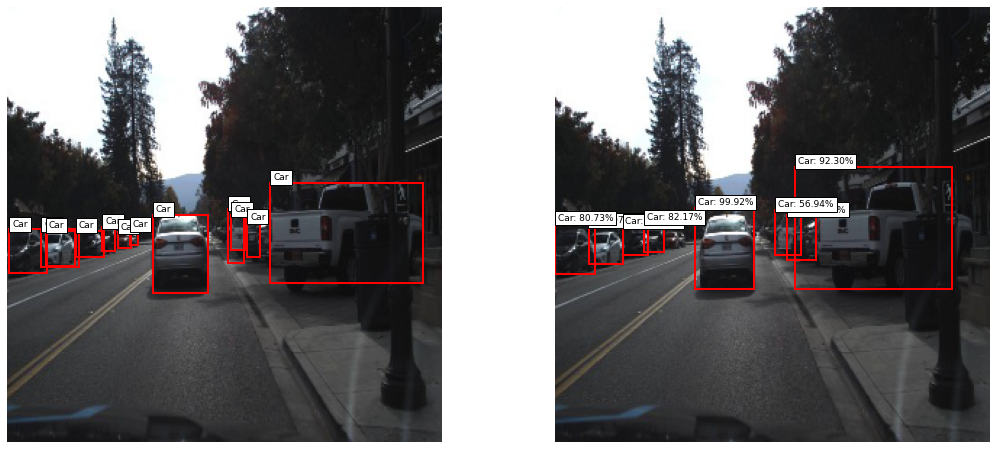

In [ ]:
fig = plt.figure(figsize=(18, 8))
ax1 = fig.add_subplot(121)
visualize_annos(batch_images[0], batch_labels[0], ax1, include_conf=False)
ax2 = fig.add_subplot(122)
visualize_annos(batch_images[0], y_pred_decoded[0], ax2, include_conf=True)

> Sub-sampled weights are good and ready for fine-tunning

# 6. Fine-tunning model

## 6.1. Freeze base network

In [ ]:
for layer in model.layers:
    layer.trainable = False
    
predictor_layers = [
    model.get_layer('conv4_3_norm_mbox_conf'), 
    model.get_layer('fc7_mbox_conf'), 
    model.get_layer('conv6_2_mbox_conf'), 
    model.get_layer('conv7_2_mbox_conf'), 
    model.get_layer('conv8_2_mbox_conf'), 
    model.get_layer('conv9_2_mbox_conf')
]

for layer in predictor_layers:
    layer.trainable = True

## 6.2. Create data generator

In [ ]:
train_dataset = DataGenerator(
    load_images_into_memory=False, 
    hdf5_dataset_path='./dataset_udacity_traffic_train.h5'
)
val_dataset = DataGenerator(
    load_images_into_memory=False, 
    hdf5_dataset_path='./dataset_udacity_traffic_val.h5'
)

# Get the number of samples in the training and validations datasets.
train_dataset_size = train_dataset.get_dataset_size()
val_dataset_size   = val_dataset.get_dataset_size()

print("Number of images in the training dataset:\t{:>6}".format(train_dataset_size))
print("Number of images in the validation dataset:\t{:>6}".format(val_dataset_size))

Loading image IDs: 100%|██████████| 4241/4241 [00:00<00:00, 5387.23it/s]
Number of images in the training dataset:	 18000
Number of images in the validation dataset:	  4241


## 6.2. Data preprocessing chain

In [ ]:
# Set batch size
batch_size = 16

ssd_data_augmentation = SSDDataAugmentation(img_height=img_height,
                                            img_width=img_width,
                                            background=mean_color)

# The encoder constructor needs the spatial dimensions of the model's predictor layers to create the anchor boxes.
predictor_sizes = [model.get_layer('conv4_3_norm_mbox_conf').output_shape[1:3],
                   model.get_layer('fc7_mbox_conf').output_shape[1:3],
                   model.get_layer('conv6_2_mbox_conf').output_shape[1:3],
                   model.get_layer('conv7_2_mbox_conf').output_shape[1:3],
                   model.get_layer('conv8_2_mbox_conf').output_shape[1:3],
                   model.get_layer('conv9_2_mbox_conf').output_shape[1:3]]

ssd_input_encoder = SSDInputEncoder(img_height=img_height,
                                    img_width=img_width,
                                    n_classes=n_classes,
                                    predictor_sizes=predictor_sizes,
                                    scales=scales,
                                    aspect_ratios_per_layer=aspect_ratios,
                                    two_boxes_for_ar1=two_boxes_for_ar1,
                                    steps=steps,
                                    offsets=offsets,
                                    clip_boxes=clip_boxes,
                                    variances=variances,
                                    matching_type='multi',
                                    pos_iou_threshold=0.5,
                                    neg_iou_limit=0.5,
                                    normalize_coords=normalize_coords)

convert_to_3_channels = ConvertTo3Channels()
# random_max_crop = RandomMaxCropFixedAR(patch_aspect_ratio=img_width/img_height)
resize = Resize(height=img_height, width=img_width)

train_generator = train_dataset.generate(batch_size=batch_size,
                                         shuffle=True,
                                         transformations=[ssd_data_augmentation],
                                         label_encoder=ssd_input_encoder,
                                         returns={'processed_images',
                                                  'encoded_labels'},
                                         keep_images_without_gt=False)

val_generator = val_dataset.generate(batch_size=batch_size,
                                     shuffle=False,
                                     transformations=[convert_to_3_channels,
                                                      resize],
                                     label_encoder=ssd_input_encoder,
                                     returns={'processed_images',
                                              'encoded_labels'},
                                     keep_images_without_gt=False)

## 6.4. Define callbacks

In [ ]:
def lr_schedule(epoch):
    if epoch < 50:
        return 0.001
    elif epoch < 100:
        return 0.0001
    else:
        return 0.00001

In [ ]:
# Define model callbacks.

model_checkpoint = ModelCheckpoint(filepath='ssd300_epoch-{epoch:02d}_loss-{loss:.4f}_val_loss-{val_loss:.4f}.h5',
                                   monitor='val_loss',
                                   verbose=1,
                                   save_best_only=True,
                                   save_weights_only=False,
                                   mode='auto',
                                   period=1)

csv_logger = CSVLogger(filename='ssd300_training_log.csv',
                       separator=',',
                       append=True)

early_stopping = EarlyStopping(monitor='val_loss',
                               min_delta=0.0,
                               patience=10,
                               verbose=1)

reduce_learning_rate = ReduceLROnPlateau(monitor='val_loss',
                                         factor=0.2,
                                         patience=3,
                                         verbose=1,
                                         epsilon=0.001,
                                         cooldown=0,
                                         min_lr=0.00001)

lr_scheduler = LearningRateScheduler(schedule=lr_schedule, 
                                     verbose=1)

callbacks = [model_checkpoint,
             csv_logger,
             early_stopping,
             reduce_learning_rate, 
             lr_scheduler]

## 6.5. Fine-tunning

In [ ]:
initial_epoch   = 50
final_epoch     = 120
steps_per_epoch = 1000

history = model.fit_generator(generator=train_generator,
                              steps_per_epoch=steps_per_epoch,
                              epochs=final_epoch,
                              callbacks=callbacks,
                              validation_data=val_generator,
                              validation_steps=ceil(val_dataset_size/batch_size),
                              initial_epoch=initial_epoch)

Epoch 51/120

Epoch 00051: LearningRateScheduler reducing learning rate to 0.0001.
1000/1000 [==============================] - 1019s 1s/step - loss: 3.3743 - val_loss: 3.5616

Epoch 00051: val_loss improved from inf to 3.56157, saving model to ssd300_epoch-51_loss-3.3743_val_loss-3.5616.h5
Epoch 52/120

Epoch 00052: LearningRateScheduler reducing learning rate to 0.0001.
1000/1000 [==============================] - 984s 984ms/step - loss: 3.3630 - val_loss: 3.5602

Epoch 00052: val_loss improved from 3.56157 to 3.56022, saving model to ssd300_epoch-52_loss-3.3630_val_loss-3.5602.h5
Epoch 53/120

Epoch 00053: LearningRateScheduler reducing learning rate to 0.0001.
1000/1000 [==============================] - 979s 979ms/step - loss: 3.3681 - val_loss: 3.5604

Epoch 00053: val_loss did not improve
Epoch 54/120

Epoch 00054: LearningRateScheduler reducing learning rate to 0.0001.
1000/1000 [==============================] - 975s 975ms/step - loss: 3.3777 - val_loss: 3.5607

Epoch 00054: v

In [5]:
log = pd.read_csv('./ssd300_training_log.csv')
log

,epoch,loss,val_loss
0,0,4.688759,4.290805
1,1,4.452247,4.253670
2,2,4.366698,4.154978
3,3,4.283295,4.108182
4,4,4.226731,4.089013
...,...,...,...
73,68,3.352305,3.559736
74,69,3.352372,3.560543
75,70,3.358970,3.559283
76,71,3.362692,3.559138


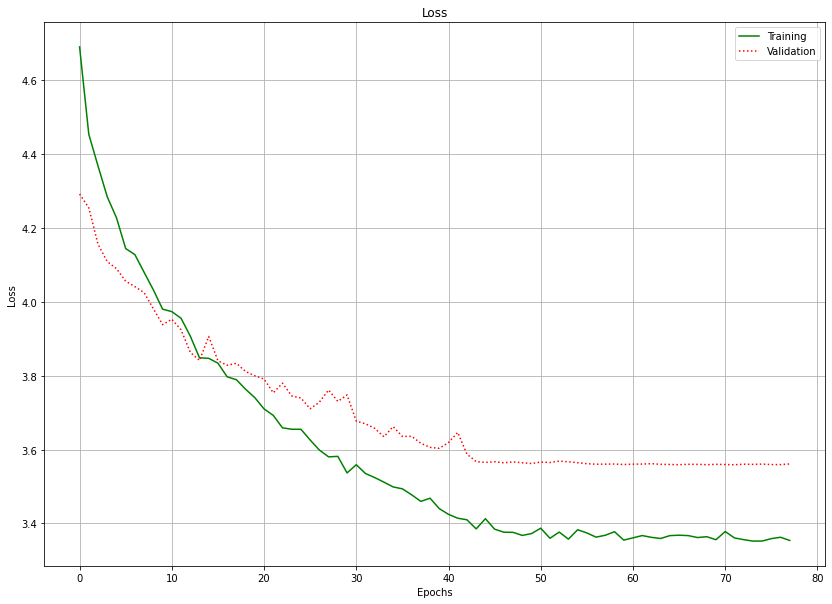

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(14, 10))

ax.set_title('Loss')
ax.plot(log['loss'], '-g', label='Training')
ax.plot(log['val_loss'], ':r', label='Validation')
ax.legend()
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
ax.grid('on')

fig.savefig('ssd_training_log.png')